# Data analysis of server(s) workload jobs

## Interpreting the data

If we take a look at the Yahoo! trace, the provided format is `job_submission_time` `nr_of_tasks_in_job` `average_task_duration` `the_runtime_of_each_task`. This only allows us to model the "Job Arrival Process" \[1], ie. the Arrival Rate, Inter-arrival Time, and Actual Runtime. However, Job Cancellation is unknown and cannot be measured from these traces. Additionally, we can analyse the job modelling characteristics Bag Of Tasks, Burstiness, and Periodicity \[1]. "Job Execution Process" \[1] details such as Job Size (# Cores), Memory Usage, and User Behaviour are not recorded in the trace, and thus cannot be analysed.

## Problems with the trace data

When examining the `job_submission_time` and `the_runtime_of_each_task` fields of the trace, the time increment is not specified. This information is important to determine to accurately interperet the data. When looking at the source for the Yahoo! workload trace \[2], the  trace comes from a cluster of approximately 2000 machines at Yahoo! (YH trace), covers three weeks in late February 2009 and early March 2009, and contains around 30,000 jobs. It also details that the running time is in task-seconds of map and reduce functions. Thus, for the `the_runtime_of_each_task` field, we can make the assumption that the floating point number is in seconds. If we make the assumption that the `job_submission_time`, we would expect the last job submission time to be close to the number of seconds in 3 weeks, which is `60 x 60 x 24 x 7 x 3 = 1814400`. When looking at the last job record in the Yahoo! trace `YH.tr`, the `job_submission_time` is 181440, thus we can make the assumption that the submission time is measure in tens of seconds.

Unfortunately, when doing the same thing for the Facebook trace `FB.tr`, the last job record has a submit time of 388171, this is vastly different to the number of seconds in 6 months, which is approximately `60 x 60 x 24 x 30 x 6 = 15552000`. It also shares no regular pattern to the last job submit time. This issue of unknown time units must be resolved before analysing the Facebook trace, and potentially the other traces.

*\[1] F. Ian, "WORKLOAD CHARACTERISATION FOR CLOUD RESOURCE MANAGEMENT," School of Engineering Macquarie University, 2020, pp. 4-7.*
 
*\[2] Y. Chen, A. Ganapathi, R. Griffith and R. Katz, "The Case for Evaluating MapReduce Performance Using Workload Suites," 2011 IEEE 19th Annual International Symposium on Modelling, Analysis, and Simulation of Computer and Telecommunication Systems, 2011, pp. 390-399, doi: 10.1109/MASCOTS.2011.12.*

## Importing the data

The first step is to import the data from the `jobs.csv` file. This file is generated from the `*.tr` trace files using the preprocessing script `process-trace.sh`. 

The `pandas` library is used to import the CSV file as a Dataframe. Pandas is a data science tool used for exploring and manipulating data. The `numpy` library is also imported to be used in conjuction with `pandas` to manipulate the Dataframe.

In [1]:
import numpy as np
import pandas as pd

with open('preprocessing/jobs.csv') as file:
    data = pd.read_csv(file)

data.set_index('job_id', inplace=True)

## How the data looks

As we can see below, the `jobs.csv` data has four fields: fields: 'job_id', 'job_submission_time', 'nr_of_tasks_in_job', and 'average_task_duration'.

Starting from time 0, each record contains a timestamp for either when a new job is submitted to the system. This give us a list of jobs in the workload trace.

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24262 entries, 0 to 24261
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   job_submission_time    24262 non-null  float64
 1   nr_of_tasks_in_job     24262 non-null  int64  
 2   average_task_duration  24262 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 758.2 KB


In [3]:
data.head()

,job_submission_time,nr_of_tasks_in_job,average_task_duration
job_id,,,
0,7.527,51,15.948893
1,15.092,34,8.723592
2,22.650,24,22.139817
3,30.004,5,1.027298
4,37.425,3,19.411553


In [4]:
data.tail()

,job_submission_time,nr_of_tasks_in_job,average_task_duration
job_id,,,
24257,181410.0,81,27.690639
24258,181418.0,7,10.193665
24259,181425.0,26,27.222939
24260,181433.0,1,1085.223348
24261,181440.0,19,6.994636


## Statistics

Below are some general statistical mesaures of the data.

In [5]:
data.describe()

,job_submission_time,nr_of_tasks_in_job,average_task_duration
count,24262.000000,24262.000000,24262.000000
mean,90727.482251,39.911590,118.784488
std,52376.743597,153.444104,526.209199
min,7.527000,1.000000,0.004283
25%,45372.075000,6.000000,6.456153
50%,90727.000000,15.000000,15.619042
75%,136084.000000,31.000000,34.323011
max,181440.000000,5900.000000,20512.714086


## Job Modelling Characteristics

### Measuring the Bag of Task Jobs

Bag of Tasks (BOT) refers to the behaviour of consecutive job submissions from the same user within a specified time period \[1].

To find the jobs which exhibit the BOT characteristic, we filter the data set to only jobs with more than 1 task in the job.



In [6]:
bot_jobs = data.query('nr_of_tasks_in_job > 1')
bot_jobs.describe()

,job_submission_time,nr_of_tasks_in_job,average_task_duration
count,23100.000000,23100.000000,23100.000000
mean,90626.777298,41.868961,119.193583
std,52351.430878,157.001703,530.504794
min,7.527000,2.000000,0.004283
25%,45353.250000,7.000000,6.467927
50%,90599.700000,16.000000,15.603409
75%,135923.000000,33.000000,34.326325
max,181440.000000,5900.000000,20512.714086


In [7]:
isolated_jobs = data.query('nr_of_tasks_in_job == 1')
isolated_jobs.describe()

,job_submission_time,nr_of_tasks_in_job,average_task_duration
count,1162.000000,1162.0,1162.000000
mean,92729.448181,1.0,110.651874
std,52860.343166,0.0,432.150268
min,111.935000,1.0,0.012002
25%,46247.875000,1.0,6.121551
50%,93733.700000,1.0,15.847855
75%,139626.750000,1.0,34.298842
max,181433.000000,1.0,5381.095989


### Results:

We find that there are 23100 BOT jobs and 1162 isolated jobs from a total of 24262 jobs in the Yahoo! workload trace.

The mean number of tasks in a BOT Job is ~42, with a median of 16. The standard deviation for the number of tasks is relatively large, at 157.

In [8]:
days = 0
n = 1
minute = 6
day = minute*60*24
freq = .6*minute

sumArrivalRate = np.zeros(int(day/freq))

for job in data['job_submission_time']:
    days = int(job/(day))
    n = int((job - (days*day))/freq)
    sumArrivalRate[n] += 1

avgArrivalRate = sumArrivalRate
for i, rate in enumerate(avgArrivalRate):
            avgArrivalRate[i] = rate/days

ar = avgArrivalRate


In [9]:
import scipy.stats
import fitDistribution as fd

dist, params, results = fd.best_fit_distribution(ar)

pdf = fd.make_pdf(dist, params)

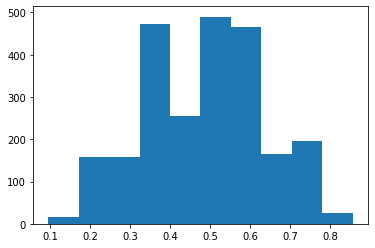

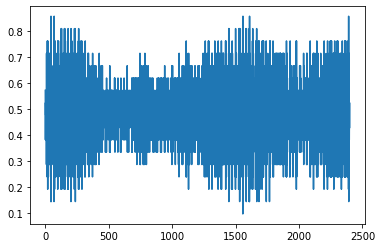

tukeylambda


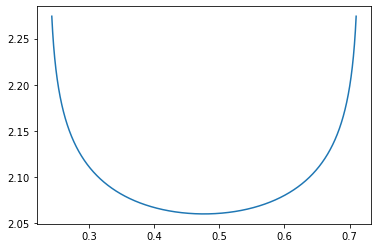

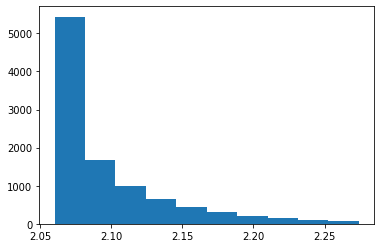

In [10]:
import matplotlib.pyplot as plt

plt.show()
plt.hist(ar)
plt.show()
plt.plot(ar)
plt.show()

print(dist.name)
plt.plot(pdf)
plt.show()
plt.hist(pdf)
plt.show()



In [11]:
import pprint as pp

pp.pprint(results)

[{'alpha': {'arg': (21.38143060089199,),
            'loc': -2.7390906919221134,
            'scale': 68.69601054576194,
            'sse': 5467.3298430797095}},
 {'anglit': {'arg': (),
             'loc': 0.47793309997839706,
             'scale': 0.48815377927901593,
             'sse': 5465.077364677845}},
 {'arcsine': {'arg': (),
              'loc': 0.019170103619241492,
              'scale': 0.8379727535236157,
              'sse': 5790.72592695897}},
 {'beta': {'arg': (3.1094694265750693, 3.18728236570403),
           'loc': 0.08390564093973141,
           'scale': 0.8052062190550855,
           'sse': 5458.084114750656}},
 {'betaprime': {'arg': (2579.751932674857, 993.2087289016308),
                'loc': -3.5263696475074537,
                'scale': 1.541578153836035,
                'sse': 5466.991537542893}},
 {'bradford': {'arg': (1.0111024480774247,),
               'loc': 0.09271761457978828,
               'scale': 0.7644252512693364,
               'sse': 5617.6158771